In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import sklearn
import itertools
import tensorflow as tf
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

# reproduction module
sys.path.insert(1, os.path.join(sys.path[0], ".."))
from reproduction.pipeline.load import load_data
from reproduction import analysis
from reproduction.pipeline import into_record

# python packages
from scipy import fftpack
from matplotlib.colors import LogNorm
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cosine
from sklearn.manifold import TSNE

In [2]:
# open/closed cell data dir
CLOSEDATADIR="/home/tkurihana/scratch-midway2/clouds/2017JAN01MOD09GA_close"
CLOSEDS = CLOSEDATADIR+"/closed.tfrecord"
OPENDATADIR="/home/tkurihana/scratch-midway2/clouds/2017JAN01MOD09GA_open"
OPENS = OPENDATADIR+"/open.tfrecord"

# same brightness but no texture to open/closed cell data dir
BCLOSEDATADIR="/home/tkurihana/scratch-midway2/clouds/2017JAN30MOD09GA_ambiguous_closed"
BCLOSEDS = BCLOSEDATADIR+"/bright_closed.tfrecord"
BOPENDATADIR="/home/tkurihana/scratch-midway2/clouds/2017JAN31MOD09GA_ambiguous_open"
BOPENS = BOPENDATADIR+"/bright_open.tfrecord"

# outputdata dir
OUTPUTDIR="/project/foster/clouds/output"
CENTERS = OUTPUTDIR+"/mod09cnn15b/encodings/m15b-enc.cluster_centres"
ENCODER_DEF = OUTPUTDIR+"/mod09cnn15b/encoder.json"
ENCODER_WEIGHTS = OUTPUTDIR+"/mod09cnn15b/encoder-585000.h5"
ENCODINGS = OUTPUTDIR+"/mod09cnn15b/encodings/m15b-enc"

In [3]:
centers = analysis.read_kmeans_centers(CENTERS)

In [4]:
k = KMeans(n_clusters=centers.shape[0], init=centers)

In [5]:
with open(ENCODER_DEF,"r") as f:
    encoder = tf.keras.models.model_from_json(f.read())
encoder.load_weights(ENCODER_WEIGHTS)

In [6]:
%reload_ext autoreload
%autoreload 2
from reproduction import analysis

In [7]:
oimgs_array = analysis._get_imgs(load_data(OPENS, encoder.input_shape[1:], repeat=False), n=30)
cimgs_array = analysis._get_imgs(load_data(CLOSEDS, encoder.input_shape[1:], repeat=False), n=30)
_oimgs_array = analysis._get_imgs(load_data(BOPENS, encoder.input_shape[1:], repeat=False), n=30)
_cimgs_array = analysis._get_imgs(load_data(BCLOSEDS, encoder.input_shape[1:], repeat=False), n=30)

In [8]:
""" t-SNE 
"""
# TODO: Functionize in analysis.py. Hopefully, more than two pair inputs is desirable 
def _plot_tsne( x,y,x_ae, y_ae, cluster=10, l1='XX open', l2 ='YY closed'):
    ''' x, y : cluster array
        x_ae : X.encs
        y_ae : Y.encs 
    '''
    fig = plt.figure(figsize=(12,9))
    cloud_type = l1+'-'+l2
    print(cluster)
    print('### Cloud Label == %s' %cloud_type)
    
    x_array = np.asarray(x_ae)
    y_array = np.asarray(y_ae)
    xidx = np.argwhere(x == cluster)
    yidx = np.argwhere(y == cluster)

    both = np.append(x_array, y_array, axis=0)
    embedded = TSNE(n_components=2).fit_transform(both)    
    print(embedded.shape)
 
    x0_list, x1_list =[], []
    y0_list, y1_list =[], []
    z0_list, z1_list =[], []
    #
    plt.figure(figsize=(12,9))
    ax = plt.subplot(111)
    for i in range(60):
        if i in  xidx  or i-30 in yidx:
            x0_list.append(embedded[i,0])
            x1_list.append(embedded[i,1])
        elif i < 30:
            y0_list.append(embedded[i,0])
            y1_list.append(embedded[i,1])
        else:
            z0_list.append(embedded[i,0])
            z1_list.append(embedded[i,1])
           
    print(len(x0_list))
    print(len(y0_list))
    print(len(z0_list))
    plt.scatter( x0_list, x1_list,label=str(cluster)+'th_'+l1+'-'+l2, color='#1f77b4')
    plt.scatter( y0_list, y1_list ,label='other_'+l1, color='#ff7f0e' )
    plt.scatter( z0_list, z1_list ,label='other_'+l2, color='#2ca02c' )
    fig.tight_layout()
    plt.legend(fontsize=15)
    plt.show()

In [9]:
""" Cosine simirality
"""
# TODO: Functionize in analysis.py.  Hopefully, more than two pair inputs is desirable 
def _plot_cosine(input_list):
    """
    INPUT
    input_list:
       [_x0,_x1]
       ==> _x0 =[      0,      [o,bc], [opens, bcloseds]] 
                  cluster-id   x.encs       AEData
    """
    def _prep_cos(current_cluster, xcluster, ycluster, x_ae, y_ae):
        xid = np.argwhere(xcluster==current_cluster)
        yid = np.argwhere(ycluster==current_cluster)
        # get latent list
        x_list, y_list = [], []
        for i in xid:
            x_list += [x_ae.encs[i[0]]]
        for j in yid:
            y_list += [y_ae.encs[j[0]]]
        return x_list, y_list
    fig = plt.figure(figsize=(8,6))
    ccs = [] 
    for indx, i in enumerate(input_list):
        idx = i[0]
        clusters = i[1]
        aes = i[2]
        _xs, _ys = _prep_cos(idx, clusters[0], clusters[1], aes[0], aes[1])
        ccs += [ [ cosine(x,y) for x in _xs for y in _ys if x is not y] ]

    for indx , i in enumerate(ccs):
        if not alist[indx][0] == 9:
            plt.hist(i, alpha=0.7, label='cluster-'+str(alist[indx][0]))
        else:
            plt.hist(i, alpha=0.7, label='cluster-'+str(alist[indx][0]), color='#17becf')
    fig.tight_layout()
    plt.legend(fontsize=18)
    plt.show()

In [10]:
#FFT
def get_spectrum(fft_array):
    # freq, ps
    freq = fftpack.fftfreq(fft_array.size)
    idx  = np.argsort(freq)
    ps   = np.abs(fft_array)**2 # poer spectrum 
    
    return freq, ps, idx

In [11]:
def _plot_fft(x, ximgs_array, cluster=100, iband=100):
    # power spectrum
    fig = plt.figure(figsize=(12,9))
    #print(len(np.argwhere(x == cluster)))
    icount = 0
    for ix , i in enumerate(np.argwhere(x == cluster)):
        for ir in range(7):
            if ir == iband:
                row = int(len(np.argwhere(x == cluster))/4)+1
                ax=plt.subplot(row,4,icount+1)
                ax.set_title(' %d th band image' %ir)
                tmp = ximgs_array[i[0],:,:,ir]
                freq, ps, idx = get_spectrum(tmp.flatten())
                plt.plot(freq[idx], ps[idx])
                icount += 1
                #ax.get_xaxis().set_visible(False)
                #ax.get_yaxis().set_visible(False)
    fig.tight_layout()
    plt.show()

In [12]:
def _plot_latent_fft(x, x_array, cluster=100, iband=100):
    # power spectrum
    fig = plt.figure(figsize=(12,9))
    #print(len(np.argwhere(x == cluster)))
    icount = 0
    for ix , i in enumerate(np.argwhere(x == cluster)):
        for ir in range(7):
            if ir == iband:
                row = int(len(np.argwhere(x == cluster))/4)+1
                ax=plt.subplot(row,4,icount+1)
                ax.set_title(' Latent Vector %d th band' %ir)
                tmp = x_array[i[0]]  # 128 1D
                freq, ps, idx = get_spectrum(tmp.flatten())
                plt.plot(freq[idx], ps[idx])
                icount += 1
                #ax.get_xaxis().set_visible(False)
                #ax.get_yaxis().set_visible(False)
    fig.tight_layout()
    plt.show()

# Sensitivity Analysis 

## Band 1

In [13]:
iband = 1

In [14]:
N = 30
opens = analysis._AEData(load_data(OPENS, encoder.input_shape[1:], repeat=False),band=iband, n=N)
closeds = analysis._AEData(load_data(CLOSEDS, encoder.input_shape[1:], repeat=False),band=iband, n=N)
bopens = analysis._AEData(load_data(BOPENS, encoder.input_shape[1:], repeat=False),band=iband, n=N)
bcloseds = analysis._AEData(load_data(BCLOSEDS, encoder.input_shape[1:], repeat=False),band=iband, n=N)

     ## Processing Band 1  ## 
     ## Processing Band 1  ## 
     ## Processing Band 1  ## 
     ## Processing Band 1  ## 


In [15]:
opens.add_encoder(encoder)
closeds.add_encoder(encoder)
bopens.add_encoder(encoder)
bcloseds.add_encoder(encoder)

In [16]:
#  cluster
k.cluster_centers_ = centers
# Number of Clusters 
num_clusters = 10
# Append
oc = np.append(opens.encs,closeds.encs, axis=0)
boc = np.append(bopens.encs,bcloseds.encs, axis=0)
both = np.append(oc, boc,  axis=0)

In [17]:
method = SpectralClustering(n_clusters=num_clusters, affinity="nearest_neighbors")
clusters = method.fit_predict(both)
o, c, bo, bc = clusters[:N], clusters[N:N*2], clusters[N*2:N*3], clusters[N*3:]

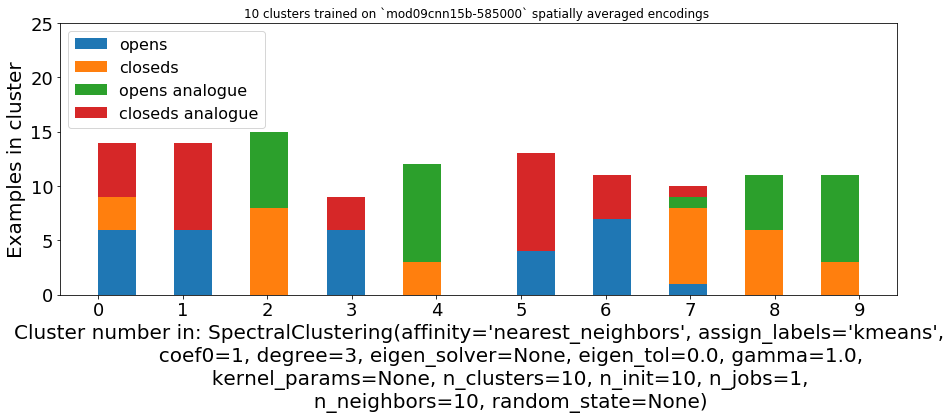

In [18]:
# Fig
plt.figure(figsize=(15, 5))
plt.hist([o,c,bo, bc], bins=num_clusters*2, 
         label=["opens", "closeds", "opens analogue", "closeds analogue"],
         stacked=True
        )
plt.xlabel("Cluster number in: "+str(method), fontsize=20)
plt.xticks(range(num_clusters))
plt.yticks([0,5,10,15,20, 25])
plt.ylabel("Examples in cluster", fontsize=20)
plt.title("%d clusters trained on `mod09cnn15b-585000` spatially averaged encodings "%(num_clusters))
plt.legend(fontsize=16, loc='upper left')
plt.tick_params(labelsize=18)

### Cloud Label == opends


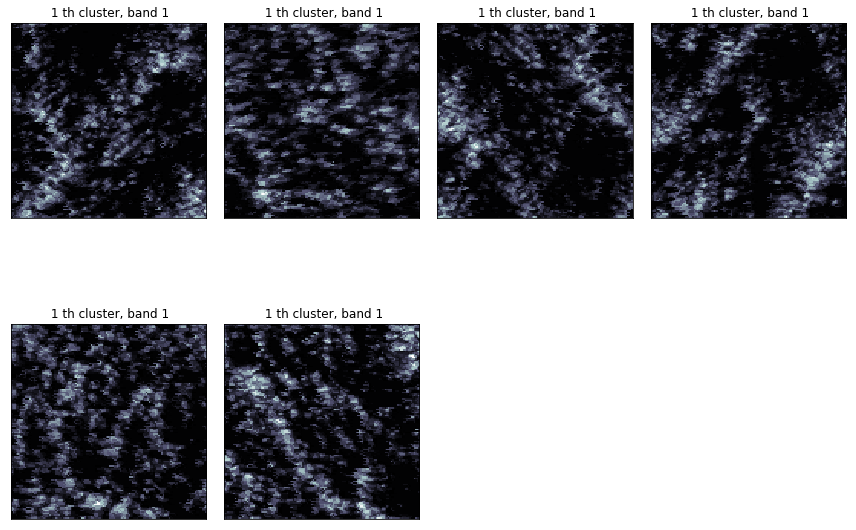

### Cloud Label == closed analogue


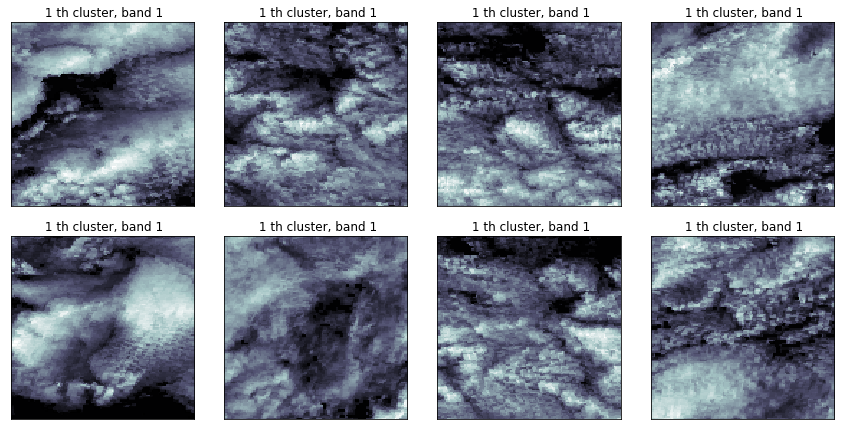

In [20]:
analysis._plot_in_cluster( o, oimgs_array,cluster=1, band=iband, cloud_label='opends')
analysis._plot_in_cluster( bc, _cimgs_array,cluster=1, band=iband, cloud_label='closed analogue')

### Cloud Label == opends


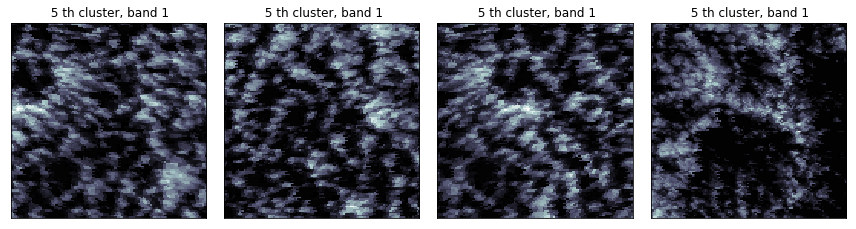

### Cloud Label == closed analogue


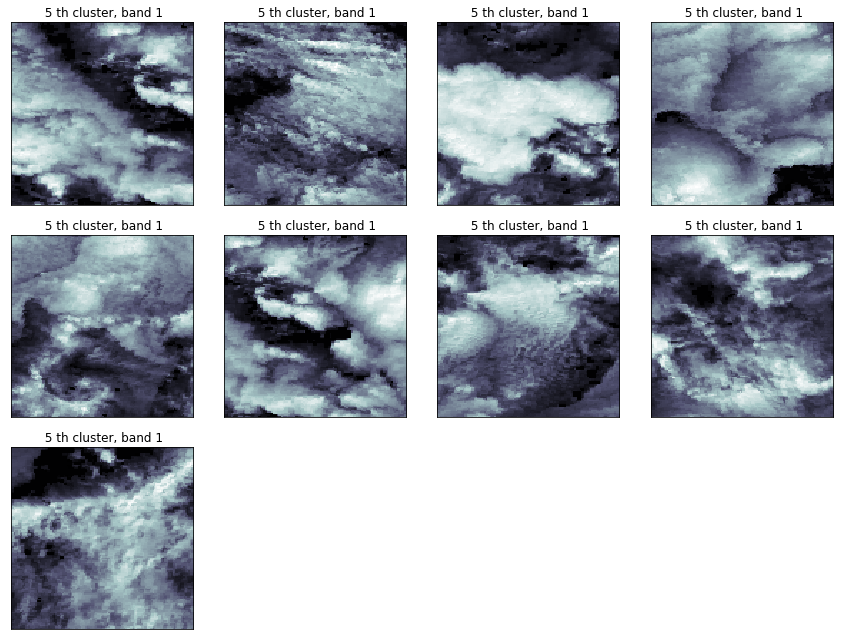

In [22]:
analysis._plot_in_cluster( o, oimgs_array,cluster=5, band=iband, cloud_label='opends')
analysis._plot_in_cluster( bc, _cimgs_array,cluster=5, band=iband, cloud_label='closed analogue')

### Cloud Label == opends


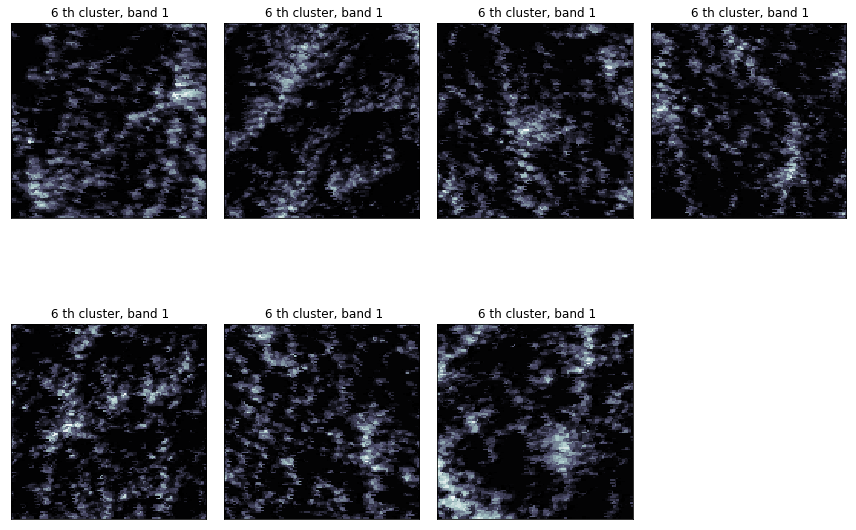

### Cloud Label == closed analogue


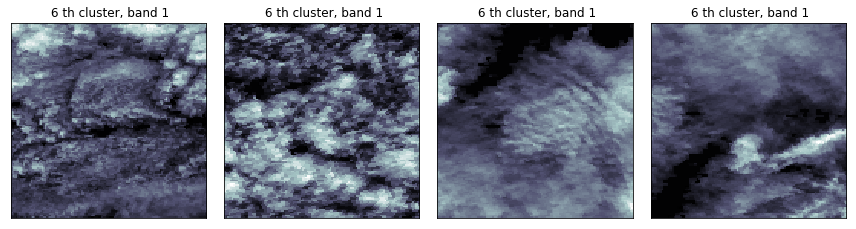

In [27]:
analysis._plot_in_cluster( o, oimgs_array,cluster=6, band=iband, cloud_label='opends')
analysis._plot_in_cluster( bc, _cimgs_array,cluster=6, band=iband, cloud_label='closed analogue')

### Cloud Label == closeds


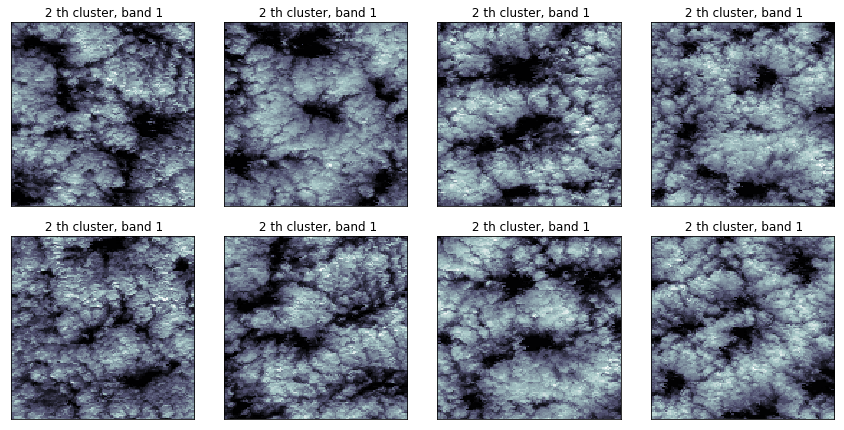

### Cloud Label == open analogue


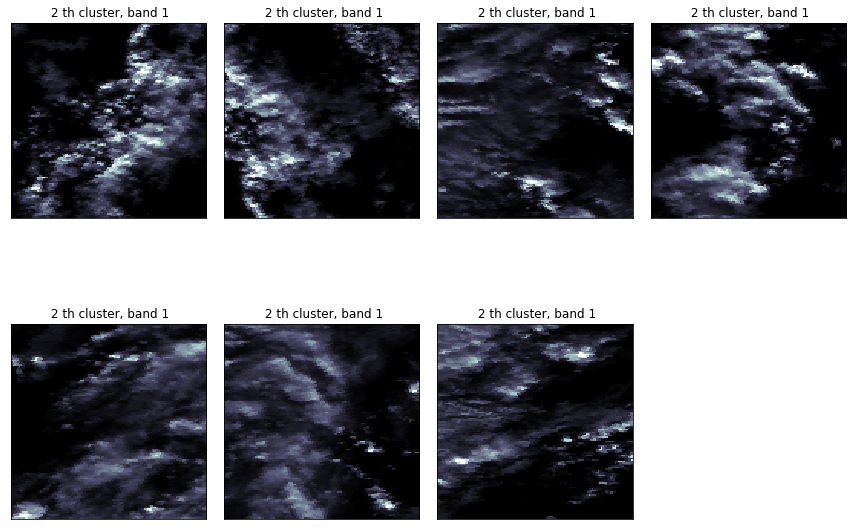

In [23]:
analysis._plot_in_cluster( c, cimgs_array,cluster=2,band=iband, cloud_label='closeds')
analysis._plot_in_cluster( bo, _oimgs_array,cluster=2,band=iband,  cloud_label='open analogue')

### Cloud Label == closeds


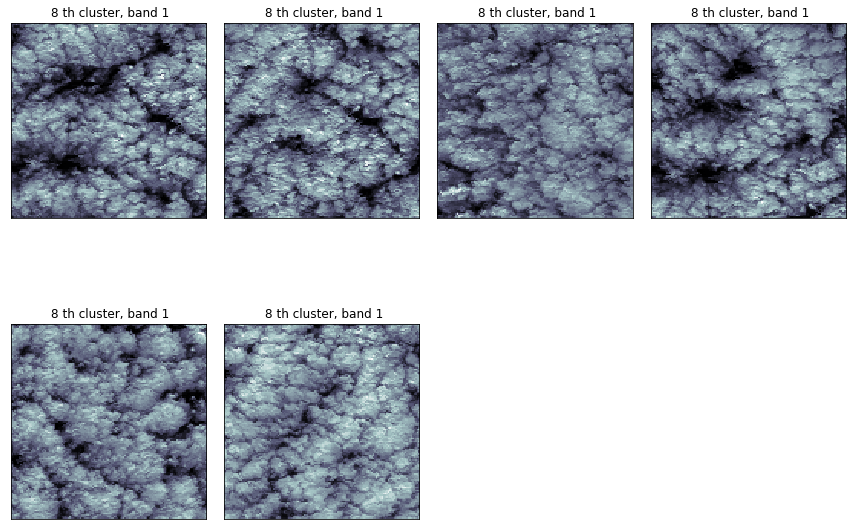

### Cloud Label == open analogue


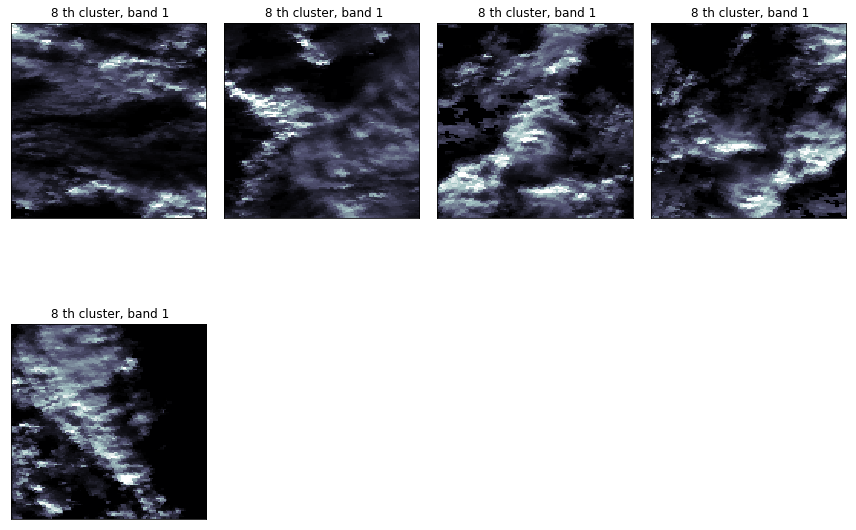

In [24]:
analysis._plot_in_cluster( c, cimgs_array,cluster=8, band=iband, cloud_label='closeds')
analysis._plot_in_cluster( bo, _oimgs_array,cluster=8, band=iband, cloud_label='open analogue')

### Cloud Label == closeds


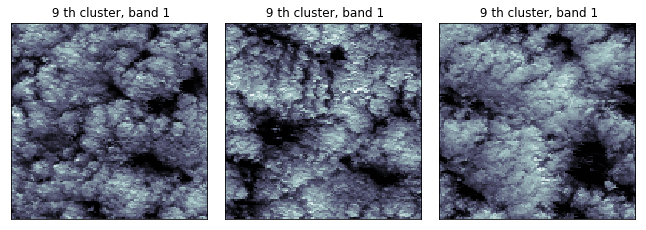

### Cloud Label == open analogue


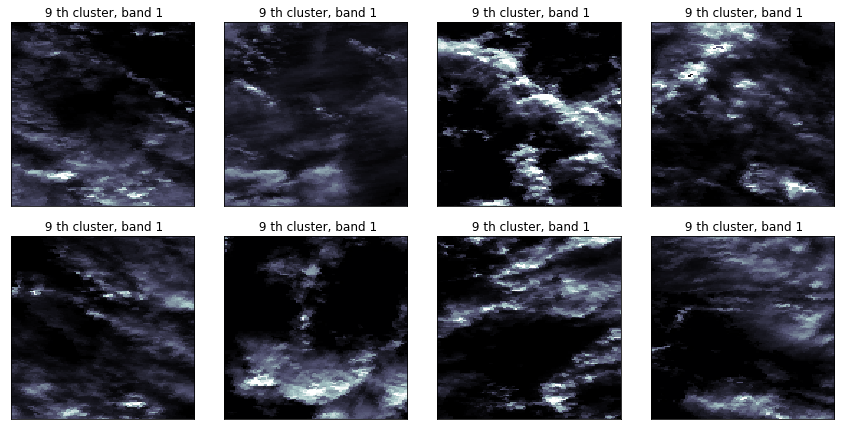

In [28]:
analysis._plot_in_cluster( c, cimgs_array,cluster=9, band=iband, cloud_label='closeds')
analysis._plot_in_cluster( bo, _oimgs_array,cluster=9, band=iband, cloud_label='open analogue')

In [25]:
x1 = [1,[o, bc],[opens,bcloseds]]
x2 = [2,[c, bo],[closeds,bopens]]
x3 = [3,[o, bc],[opens,bcloseds]]
x4 = [4,[c, bo],[closeds,bopens]]
x5 = [5,[o, bc],[opens,bcloseds]]
x6 = [6,[o, bc],[opens,bcloseds]]
x8 = [8,[c, bo],[closeds,bopens]]
x9 = [9,[c, bo],[closeds,bopens]]
alist = [x1,x2,x3,x4, x5,x6,x8,x9]

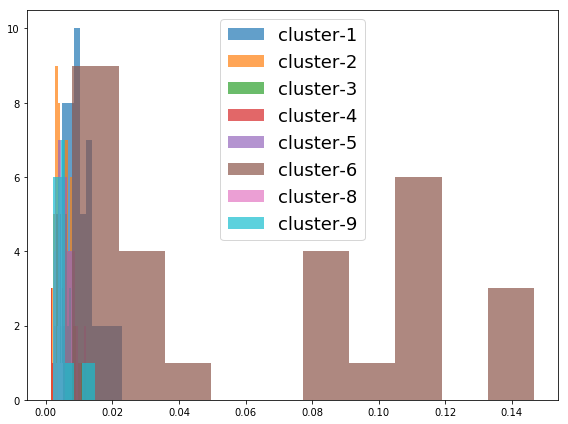

In [26]:
_plot_cosine(alist)

t - SNE

1
### Cloud Label == opens-closed analogue
(60, 2)
14
24
22


<Figure size 864x648 with 0 Axes>

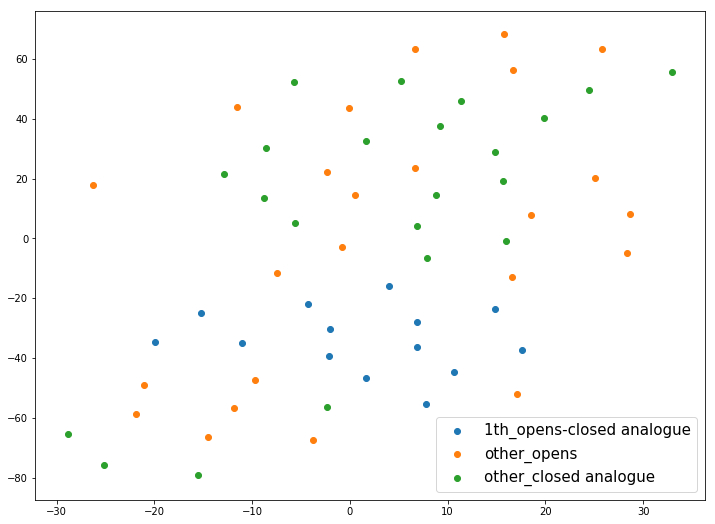

In [34]:
_plot_tsne(o, bc,opens.encs,bcloseds.encs,cluster=1, l1='opens', l2 ='closed analogue')

5
### Cloud Label == opens-closed analogue
(60, 2)
13
26
21


<Figure size 864x648 with 0 Axes>

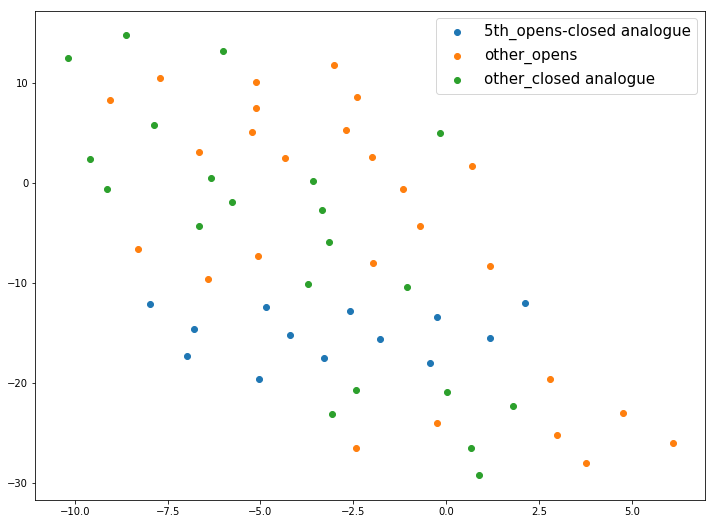

In [41]:
_plot_tsne(o, bc,opens.encs,bcloseds.encs,cluster=5, l1='opens', l2 ='closed analogue')

6
### Cloud Label == opens-closed analogue
(60, 2)
11
23
26


<Figure size 864x648 with 0 Axes>

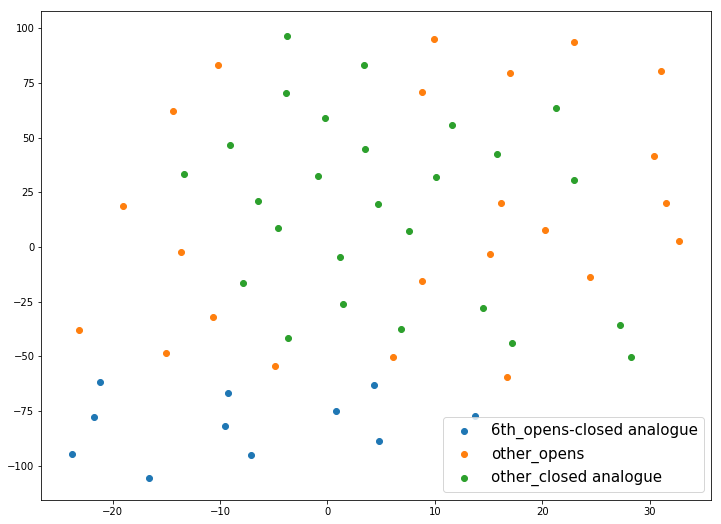

In [40]:
_plot_tsne(o, bc,opens.encs,bcloseds.encs,cluster=6, l1='opens', l2 ='closed analogue')

2
### Cloud Label == closeds-open analogue
(60, 2)
15
22
23


<Figure size 864x648 with 0 Axes>

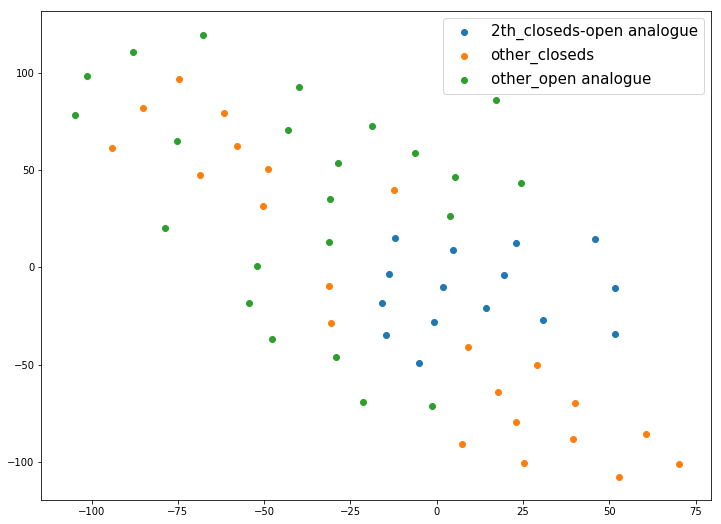

In [44]:
_plot_tsne(c, bo, closeds.encs,bopens.encs,cluster=2, l1='closeds', l2 ='open analogue')

8
### Cloud Label == closeds-open analogue
(60, 2)
11
24
25


<Figure size 864x648 with 0 Axes>

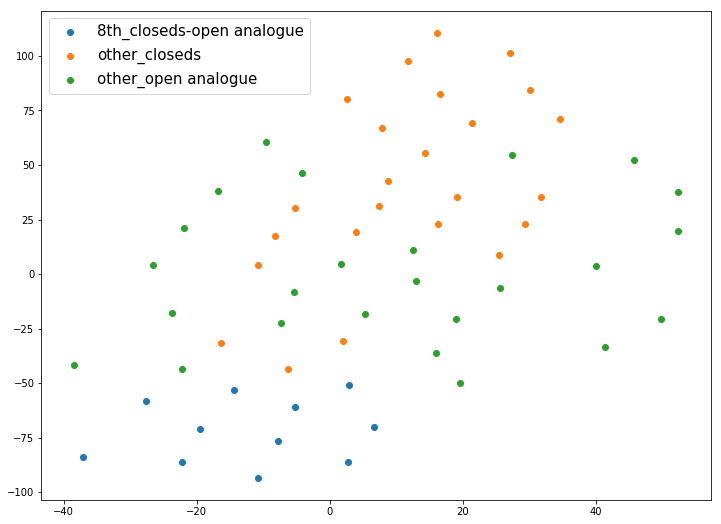

In [45]:
_plot_tsne(c, bo, closeds.encs,bopens.encs,cluster=8, l1='closeds', l2 ='open analogue')

9
### Cloud Label == closeds-open analogue
(60, 2)
11
27
22


<Figure size 864x648 with 0 Axes>

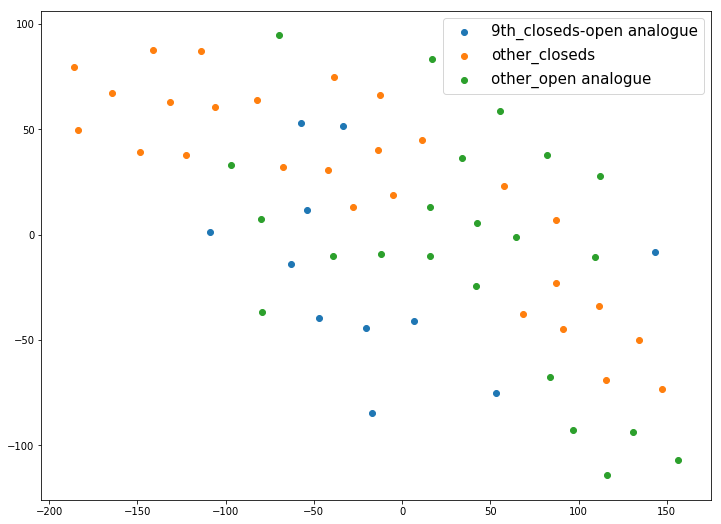

In [51]:
_plot_tsne(c, bo, closeds.encs,bopens.encs,cluster=9, l1='closeds', l2 ='open analogue')

MEMO: band 1, cluster 9 is not gatherd as one set. The cluster distriutes wider thant others.

FFT Cluster 1

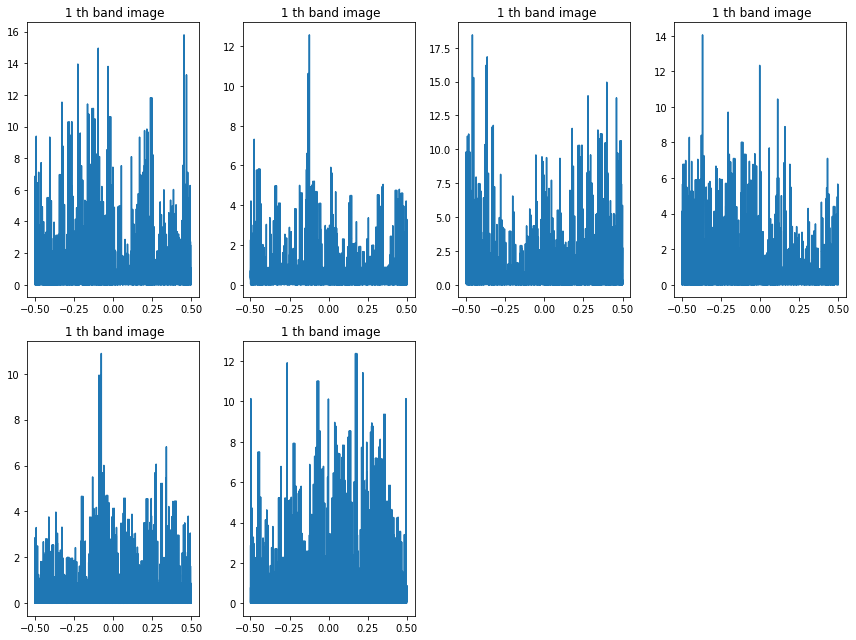

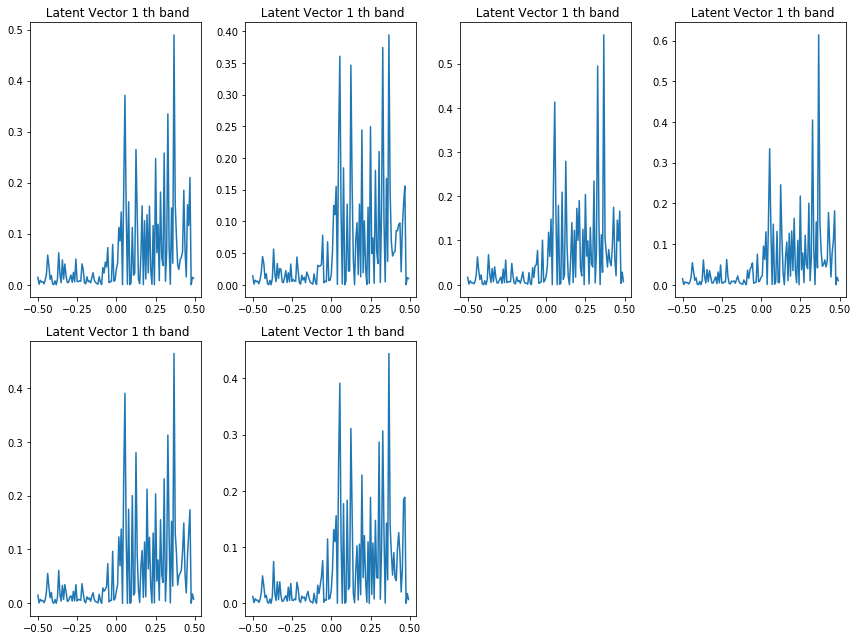

In [53]:
_plot_fft(o, oimgs_array, cluster=1, iband=1)
_plot_latent_fft(o, opens.encs, cluster=1, iband=1)

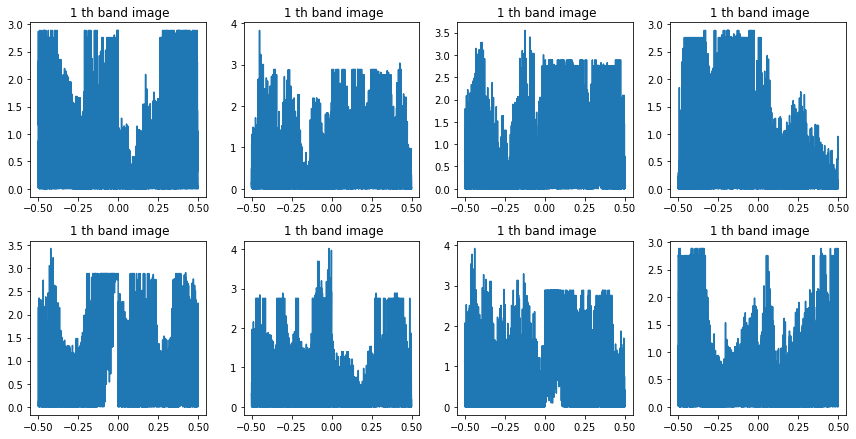

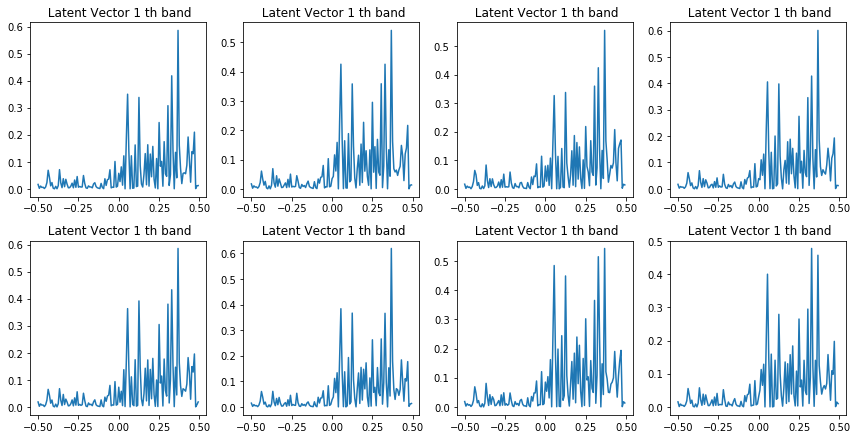

In [59]:
_plot_fft(bc, _cimgs_array, cluster=1, iband=1)
_plot_latent_fft(bc, bcloseds.encs, cluster=1, iband=1)

FFT Cluster 5

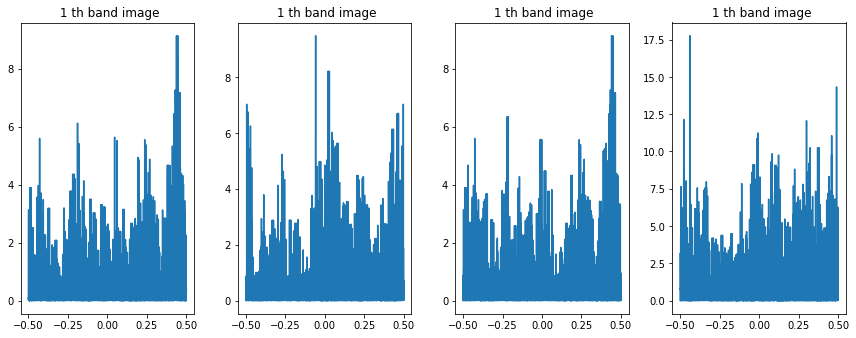

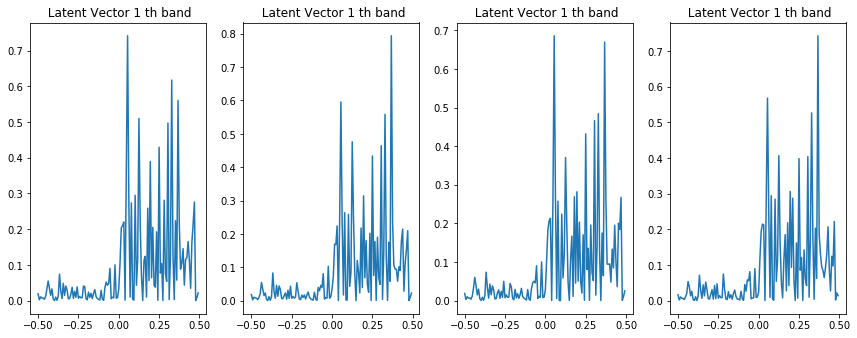

In [60]:
_plot_fft(o, oimgs_array, cluster=5, iband=1)
_plot_latent_fft(o, opens.encs, cluster=5, iband=1)

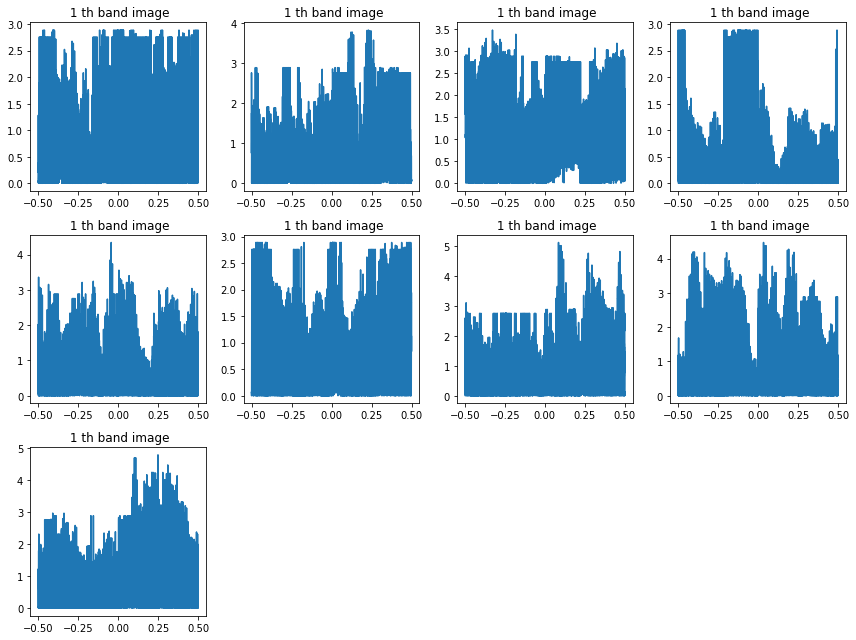

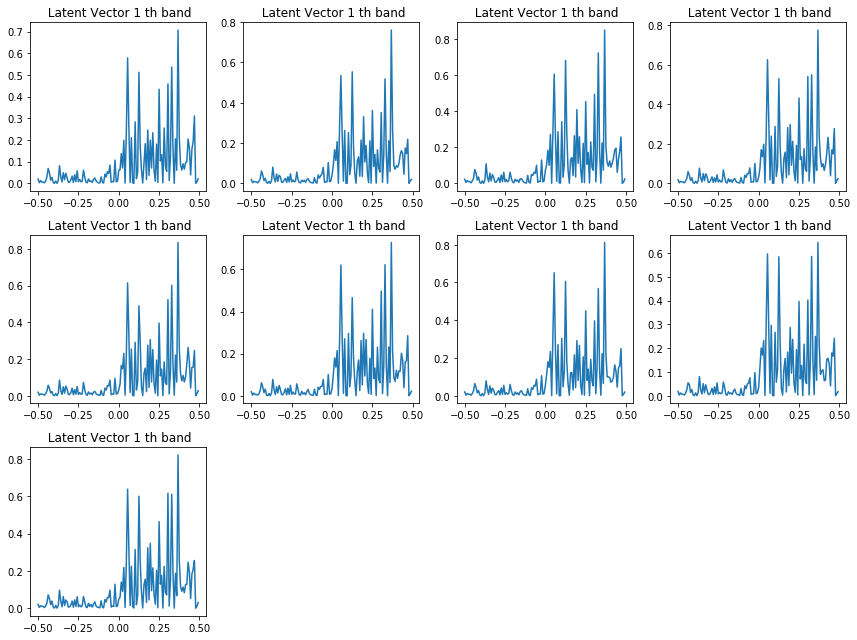

In [61]:
_plot_fft(bc, _cimgs_array, cluster=5, iband=1)
_plot_latent_fft(bc, bcloseds.encs, cluster=5, iband=1)

FFT Cluster 6

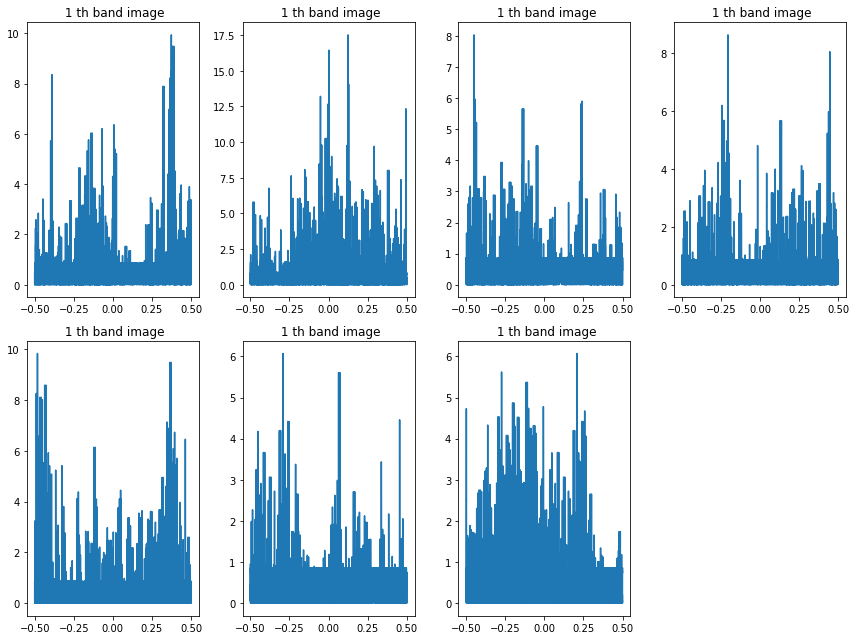

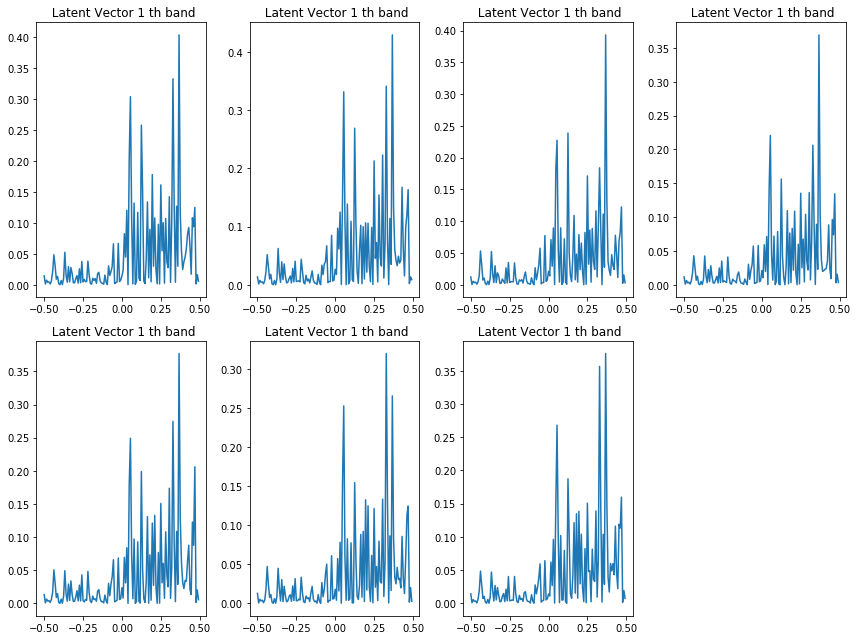

In [62]:
_plot_fft(o, oimgs_array, cluster=6, iband=1)
_plot_latent_fft(o, opens.encs, cluster=6, iband=1)

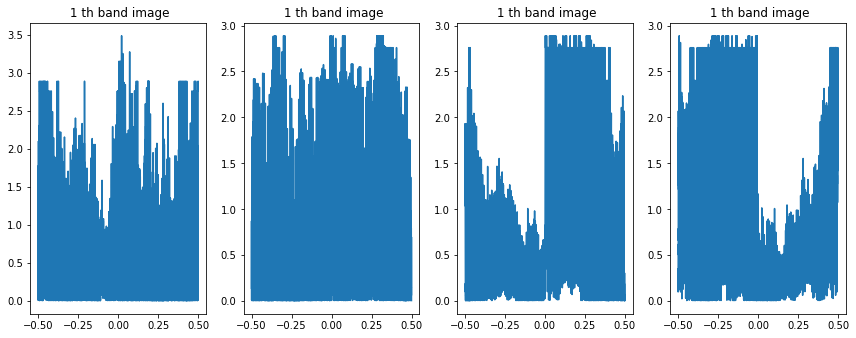

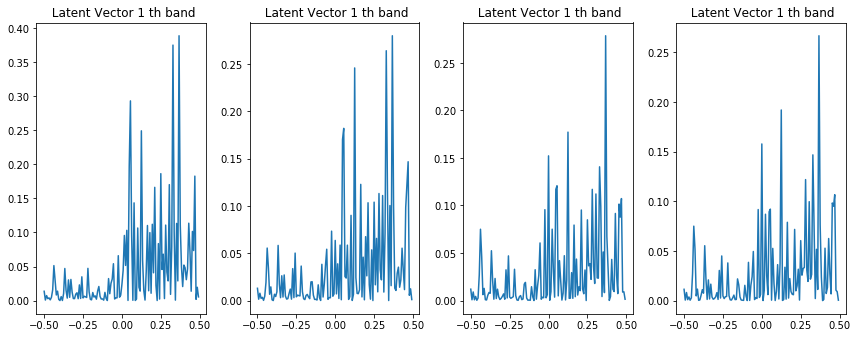

In [63]:
_plot_fft(bc, _cimgs_array, cluster=6, iband=1)
_plot_latent_fft(bc, bcloseds.encs, cluster=6, iband=1)

FFT Cluster 2

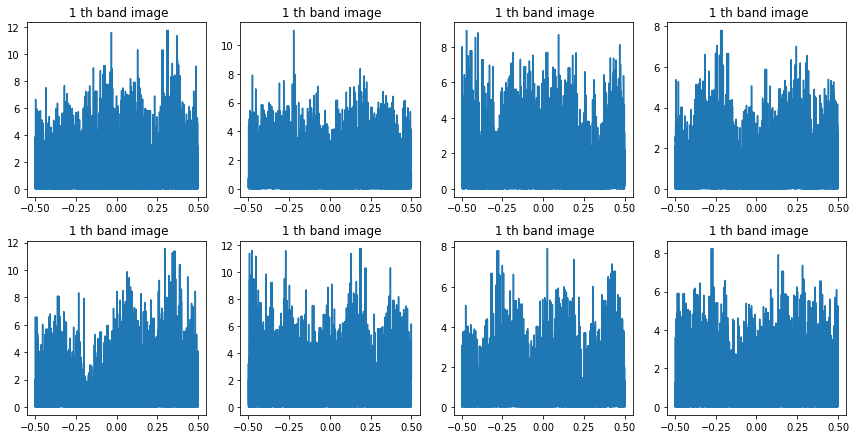

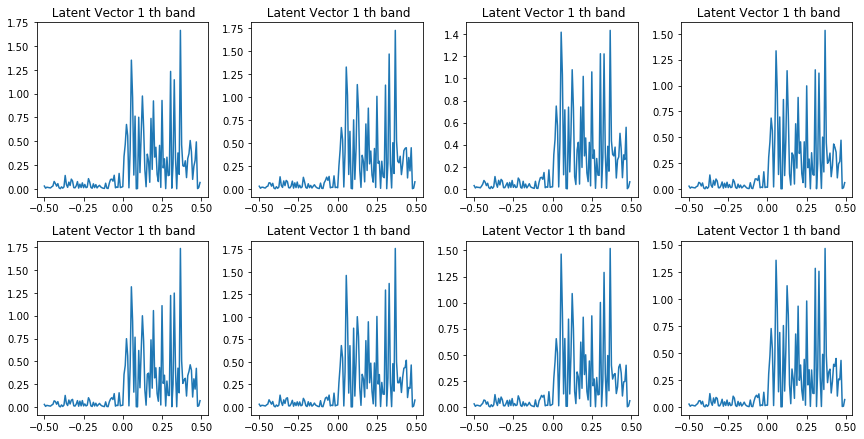

In [64]:
_plot_fft(c, cimgs_array, cluster=2, iband=1)
_plot_latent_fft(c, closeds.encs, cluster=2, iband=1)

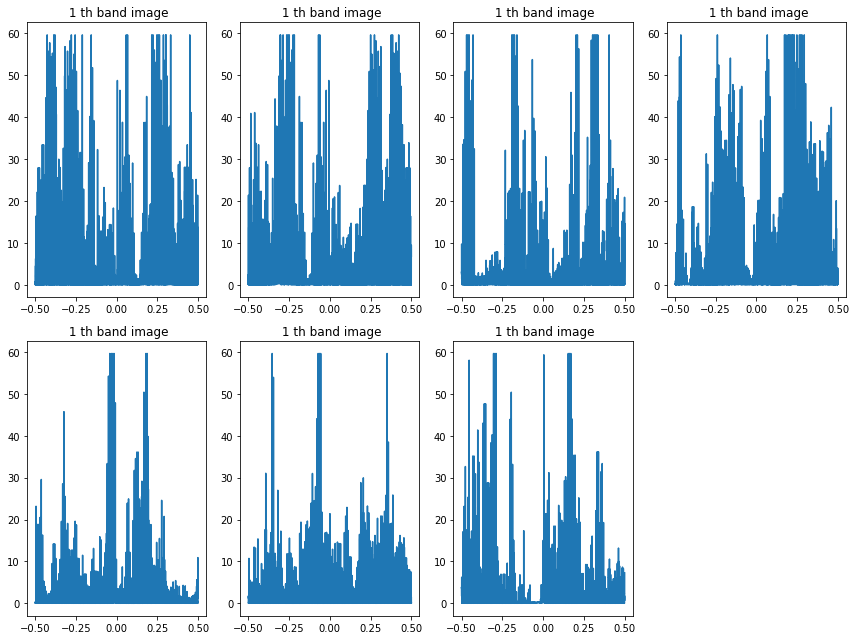

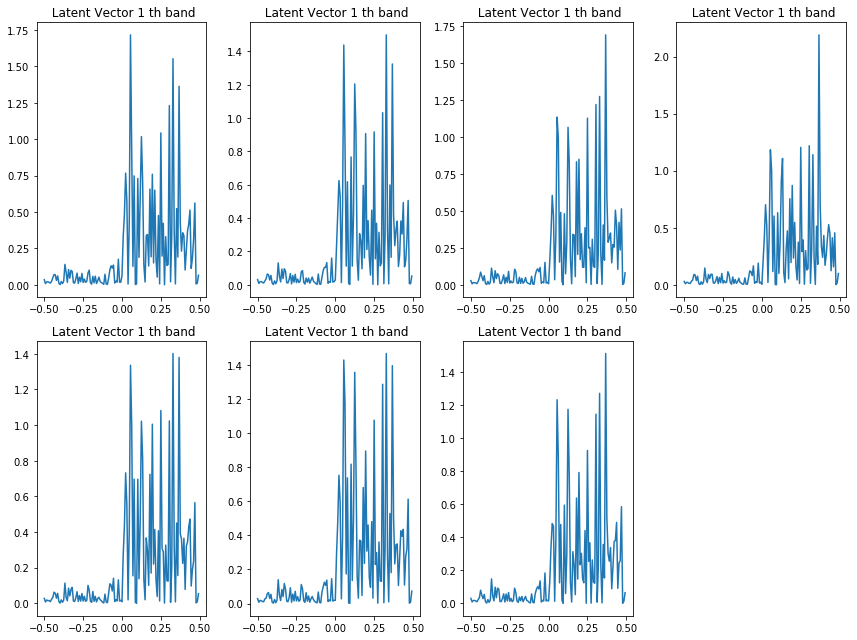

In [65]:
_plot_fft(bo, _oimgs_array, cluster=2, iband=1)
_plot_latent_fft(bo, bopens.encs, cluster=2, iband=1)

FFT Cluster 8

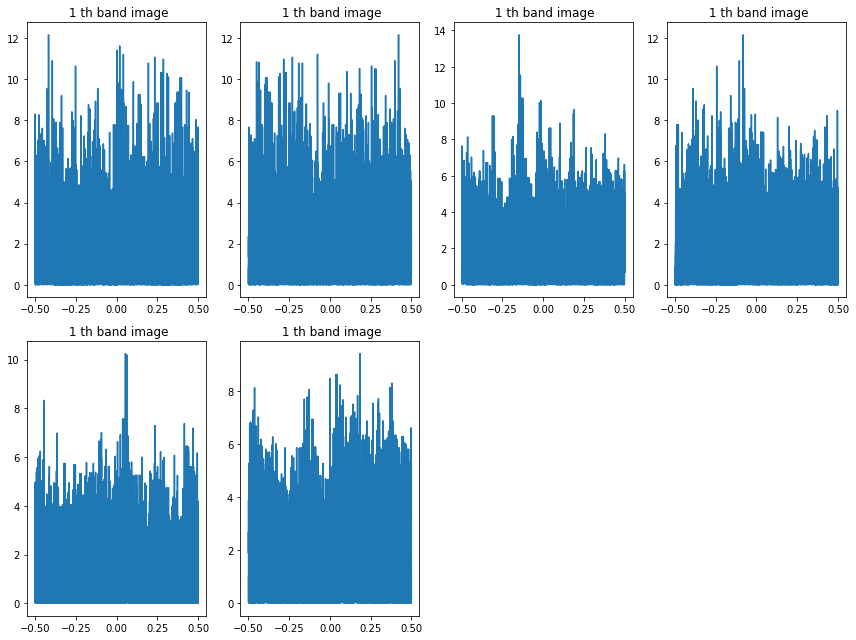

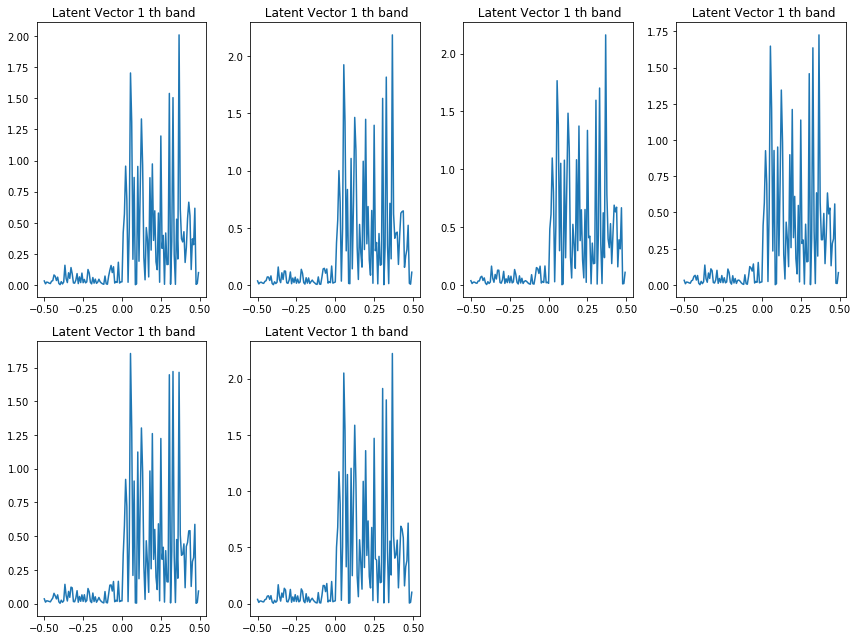

In [66]:
_plot_fft(c, cimgs_array, cluster=8, iband=1)
_plot_latent_fft(c, closeds.encs, cluster=8, iband=1)

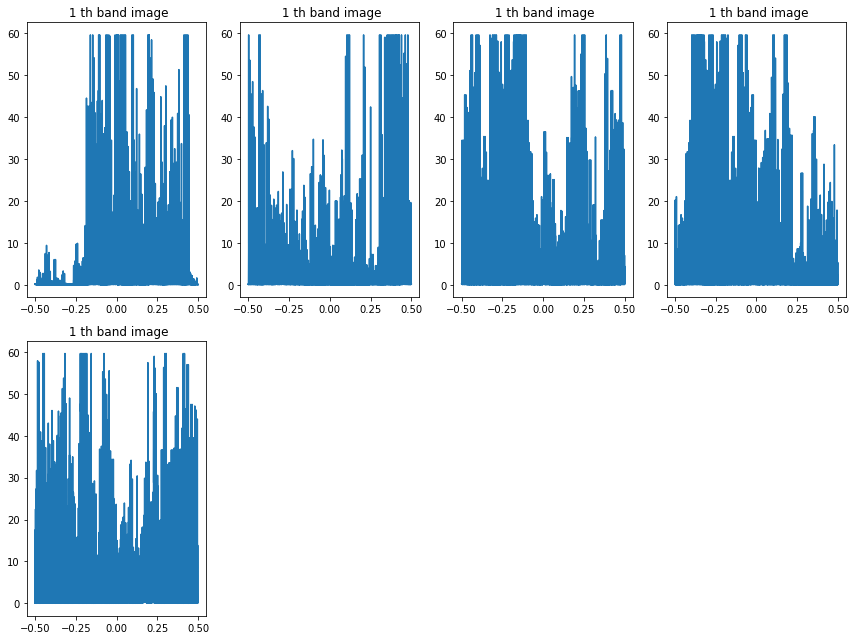

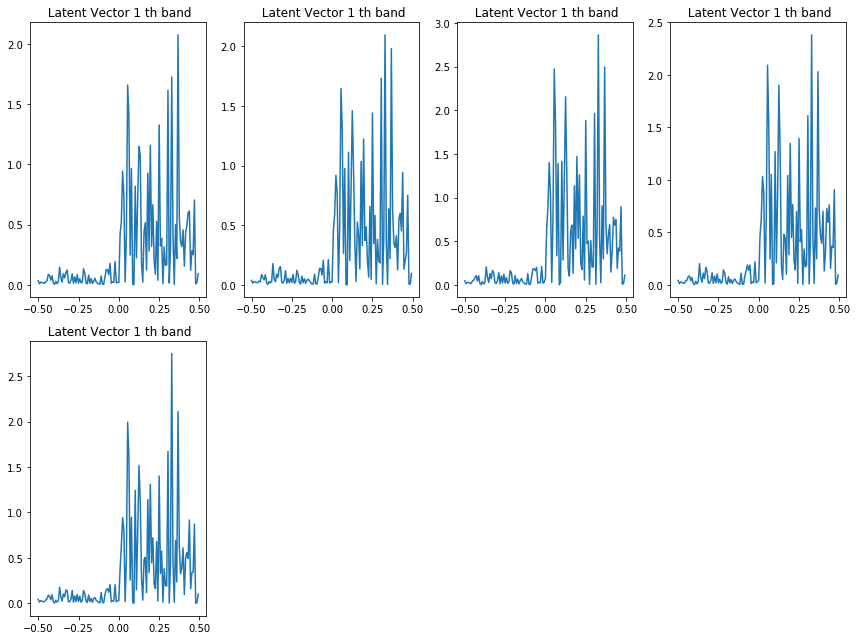

In [67]:
_plot_fft(bo, _oimgs_array, cluster=8, iband=1)
_plot_latent_fft(bo, bopens.encs, cluster=8, iband=1)

FFT Cluster 9

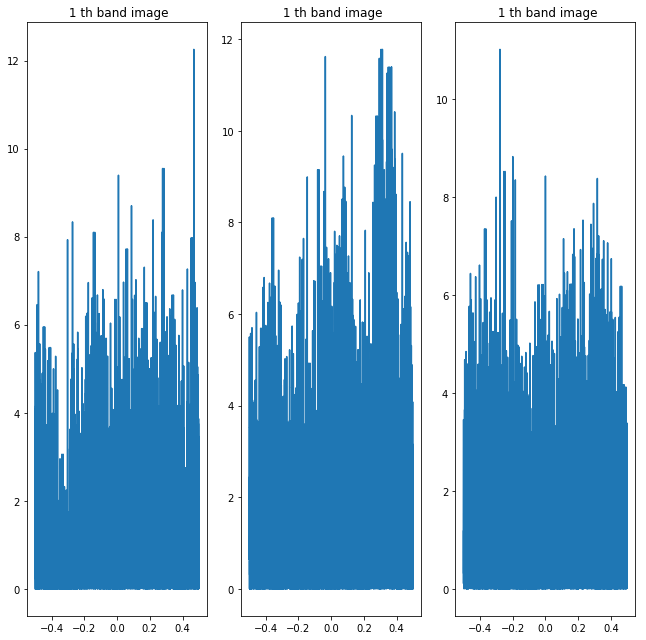

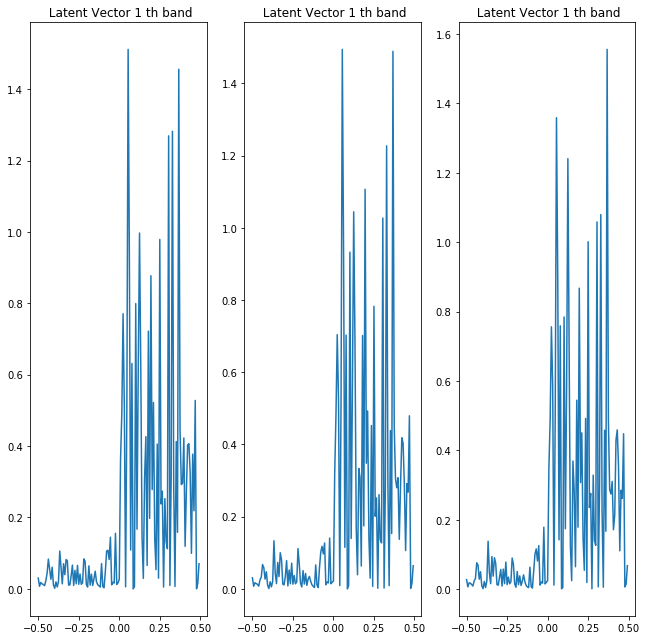

In [68]:
_plot_fft(c, cimgs_array, cluster=9, iband=1)
_plot_latent_fft(c, closeds.encs, cluster=9, iband=1)

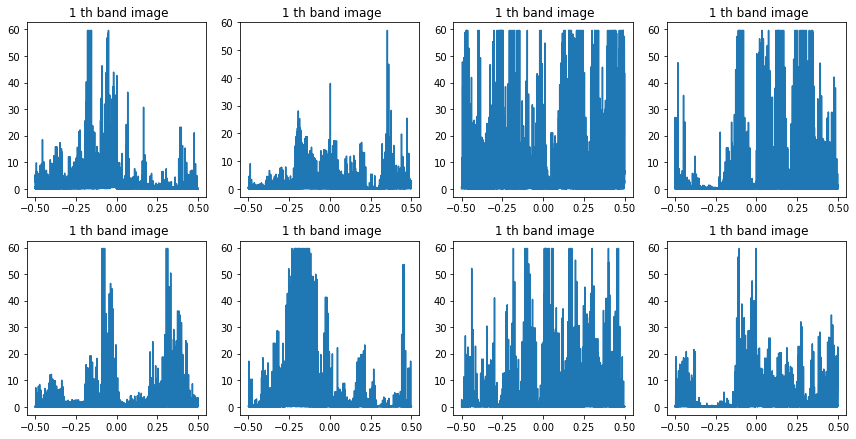

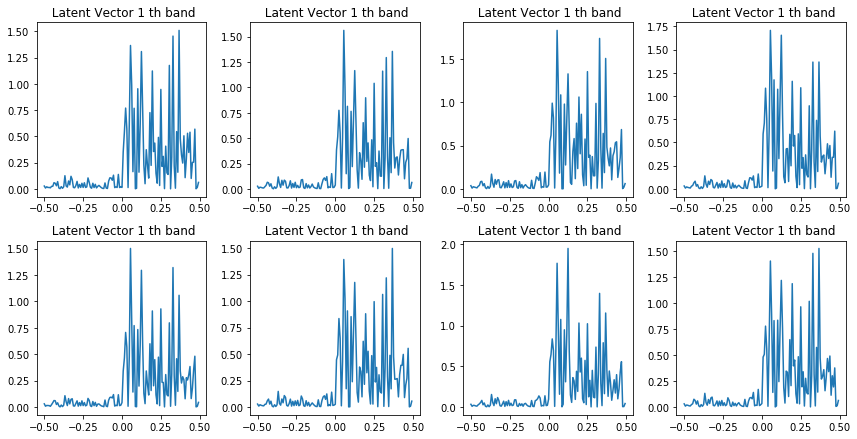

In [69]:
_plot_fft(bo, _oimgs_array, cluster=9, iband=1)
_plot_latent_fft(bo, bopens.encs, cluster=9, iband=1)

In [70]:
def _mod_cluster(opens, closeds, bopens, bcloseds, crange, ncol=3,  N=30):
    #  cluster
    k.cluster_centers_ = centers
    # Append
    oc = np.append(opens.encs,closeds.encs, axis=0)
    boc = np.append(bopens.encs,bcloseds.encs, axis=0)
    both = np.append(oc, boc,  axis=0)
    if max(crange) < 21:
        fig = plt.figure(figsize=(15,5))
    else:
        fig = plt.figure(figsize=(15,10))
    row = int(len(crange)/ncol)+1
    for idx, iclus in enumerate(crange):
        num_clusters = iclus 
        method = SpectralClustering(n_clusters=num_clusters, affinity="nearest_neighbors")
        clusters = method.fit_predict(both)
        o, c, bo, bc = clusters[:N], clusters[N:N*2], clusters[N*2:N*3], clusters[N*3:]
        # Fig
        ax = plt.subplot(row,ncol,idx+1)
        plt.hist([o,c,bo, bc], bins=num_clusters*2, 
                 label=["opens", "closeds", "opens analogue", "closeds analogue"],
                 stacked=True
                )
        ax.set_xticks(range(num_clusters))
        ax.set_title("%d clusters" %iclus)
        ax.tick_params(labelsize=10)
    fig.tight_layout()
    plt.show()

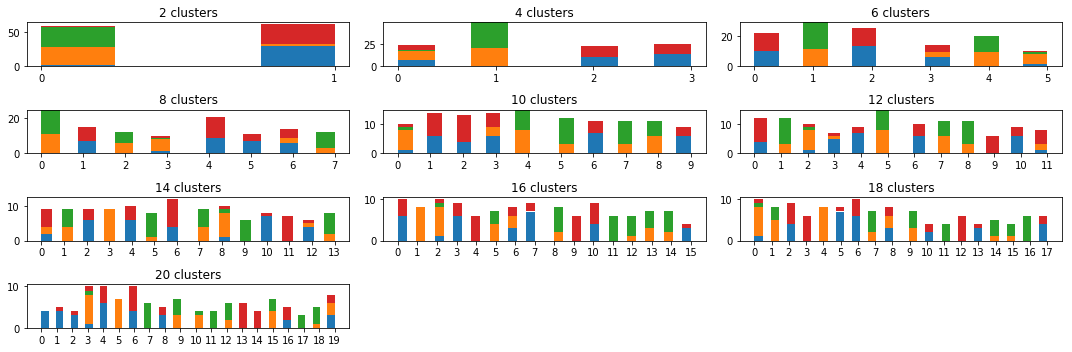

In [71]:
crange = np.arange(2,21,2)
_mod_cluster(opens, closeds, bopens, bcloseds, crange, ncol=3)

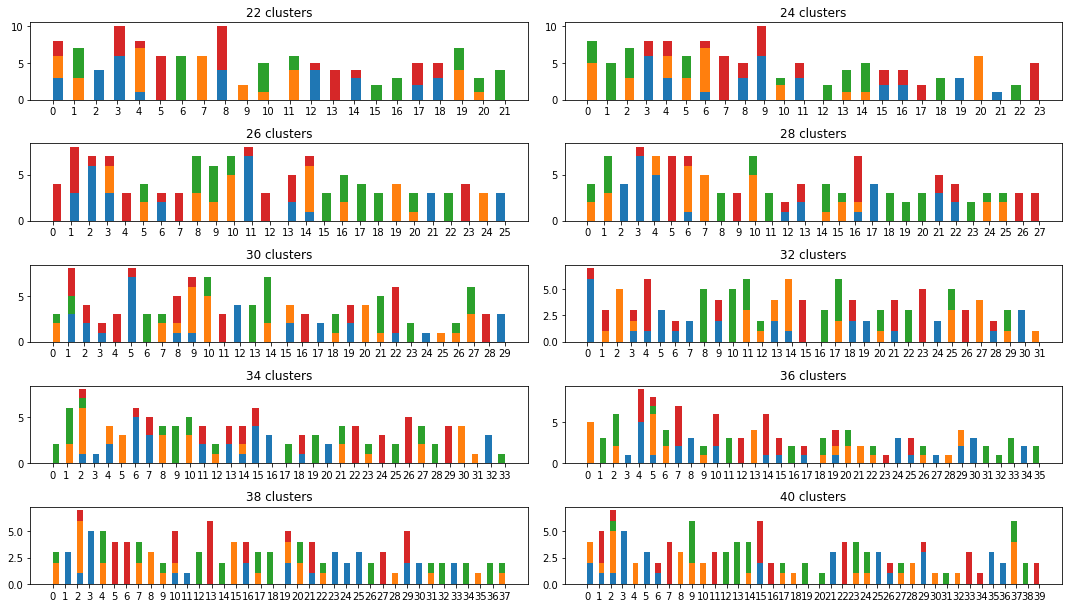

In [72]:
crange = np.arange(22,41,2)
_mod_cluster(opens, closeds, bopens, bcloseds, crange, ncol=2)